In [1]:
import ee

In [2]:
ee.Authenticate()

True

In [3]:
ee.Initialize()

In [4]:
#import the dataset
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD")

In [5]:
# Initial date of interest (inclusive).
i_date = '2000-01-01'

## Final date of interest (exclusive).
f_date = '2024-01-01'

start_year = 2000
end_year = 2024

## Total Annual Rainfall

In [6]:
#year 2017
year = 2017
startDate = ee.Date.fromYMD(year, 1, 1)
endDate = startDate.advance(1, 'year')
filtered = chirps.filter(ee.Filter.date(startDate, endDate))
total = filtered.reduce(ee.Reducer.sum())

In [7]:
#Total annual Rainfall 2017
import geemap
Map = geemap.Map()

palette = ['#ffffcc','#a1dab4','#41b6c4','#2c7fb8','#253494']
visParams = {
    'min':0,
    'max': 2000,
    'palette': palette
}

Map.addLayer(total, visParams, 'Total Precipitation')

In [11]:
Map

Map(bottom=1299.0, center=[4.390228926463396, 51.74075108976869], controls=(WidgetControl(options=['position',…

In [59]:
#Total Rainfall in Kenya

In [10]:

#import shapefile
project_area = ee.FeatureCollection("projects/connect-gaea/assets/project_areas")
aoi = project_area.geometry()
Map.addLayer(aoi, {}, 'aoi')


In [12]:
scale = 5000
# Reduce the region
stats = total.reduceRegion(
    reducer = ee.Reducer.mean(),
    geometry = aoi,
    scale = scale
)

# Print the precipitation sum
precipitation_sum = stats.get('precipitation_sum').getInfo()
print("Precipitation sum:", precipitation_sum, "mm")


Precipitation sum: 1588.4501567503746 mm


In [13]:
#clip
total_westernke = total.clip(aoi)
Map.addLayer(total_westernke, visParams, 'Total Precipitation (Western_kenya)')


In [14]:
Map

Map(bottom=16676.0, center=[0.08789059053082422, 36.73426856727007], controls=(WidgetControl(options=['positio…

## Calculating time series for rainfall


In [21]:
# Define the initial and final years
initial_year = 2000
final_year = 2023


# Function to calculate rainfall for 1 year
def yearly_rainfall(year):
    # Create a date object for the start of the year
    start_date = ee.Date.fromYMD(year, 1, 1)
    # Advance the start date by 1 year to get the end date
    end_date = start_date.advance(1, 'year')
    
    # Filter the CHIRPS dataset for the specified year
    filtered = chirps.filterDate(start_date, end_date)
    
    # Reduce the filtered dataset to calculate the sum and mean of precipitation
    total_precipitation = filtered.reduce(ee.Reducer.sum())
    mean_precipitation = filtered.reduce(ee.Reducer.mean())
    
    # Calculate the sum of precipitation within the AOI
    stats = total_precipitation.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=5000
    )
    
    # Create a feature with properties for year and precipitation
    feature = ee.Feature(
        None,
        {
            'year': year,
            'precipitation': stats.get('precipitation_sum')
        }
    )
    
    return feature

# Iterate over each year in the range and calculate rainfall
yearly_rainfall_features = []
for year in range(initial_year, final_year + 1):
    yearly_rainfall_features.append(yearly_rainfall(year))

# Convert the list of features to an Earth Engine FeatureCollection
yearly_rainfall_fc = ee.FeatureCollection(yearly_rainfall_features)

# Print the first feature to verify
print(yearly_rainfall_fc.first().getInfo())

{'type': 'Feature', 'geometry': None, 'id': '0', 'properties': {'precipitation': 683647.8222572688, 'year': 2000}}


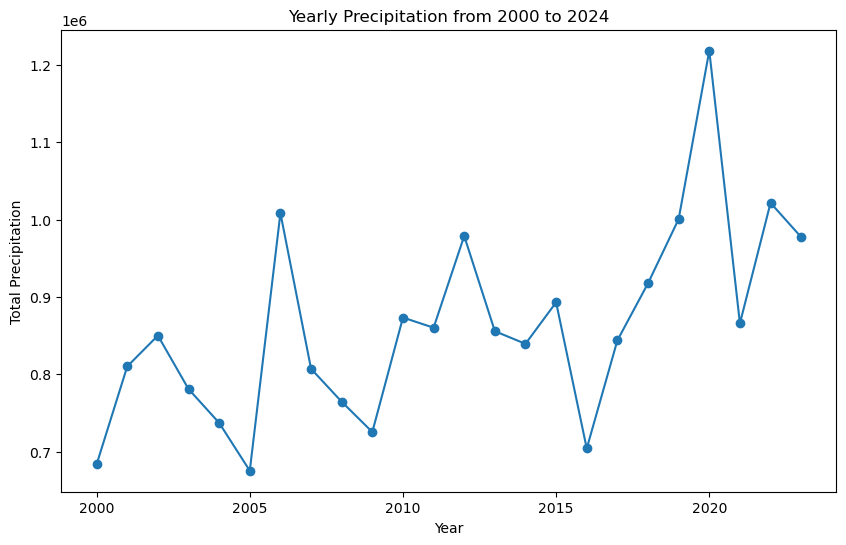

In [22]:
import matplotlib.pyplot as plt

# Extract the data from the FeatureCollection
data = yearly_rainfall_fc.getInfo()['features']

# Get the years and precipitation values
years = [feature['properties']['year'] for feature in data]
precipitation = [feature['properties']['precipitation'] for feature in data]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(years, precipitation, marker='o')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Total Precipitation')
plt.title('Yearly Precipitation from 2000 to 2024')

# Show the plot
plt.show()


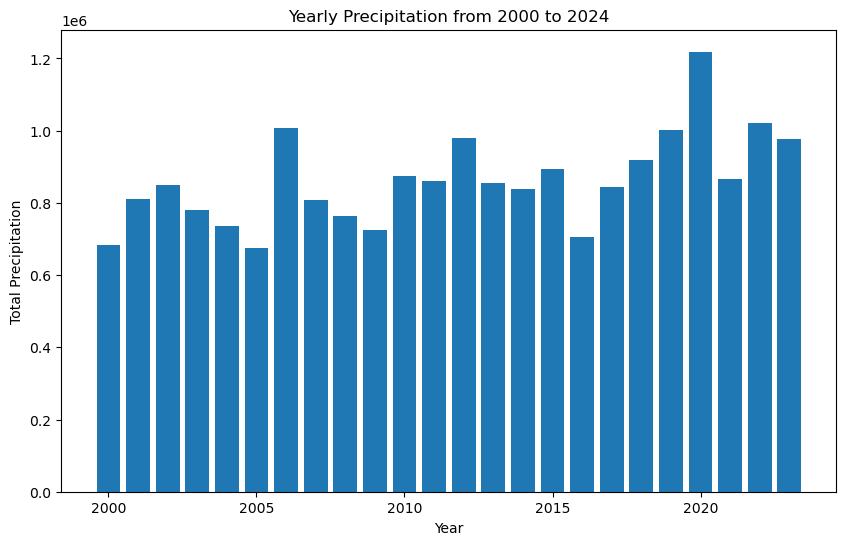

In [23]:


# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(years, precipitation)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Total Precipitation')
plt.title('Yearly Precipitation from 2000 to 2024')

# Show the plot
plt.show()


In [31]:
# Function to calculate average rainfall for 1 year
def yearly_avg_rainfall(year):
    # Create a date object for the start of the year
    start_date = ee.Date.fromYMD(year, 1, 1)
    # Advance the start date by 1 year to get the end date
    end_date = start_date.advance(1, 'year')
    
    # Filter the CHIRPS dataset for the specified year
    filtered = chirps.filterDate(start_date, end_date)
    
    # Reduce the filtered dataset to calculate the mean of precipitation
    mean_precipitation = filtered.reduce(ee.Reducer.mean())
    
    # Calculate the mean of precipitation within the AOI
    stats = mean_precipitation.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=5000
    )
    
    # Create a feature with properties for year and average precipitation
    feature = ee.Feature(
        None,
        {
            'year': year,
            'avg_precipitation': stats.get('precipitation_mean')
        }
    )
    
    return feature

# Iterate over each year in the range and calculate average rainfall
yearly_avg_rainfall_features = []
for year in range(initial_year, final_year + 1):
    yearly_avg_rainfall_features.append(yearly_avg_rainfall(year))

# Convert the list of features to an Earth Engine FeatureCollection
yearly_avg_rainfall_fc = ee.FeatureCollection(yearly_avg_rainfall_features)

# Print the first feature to verify
print(yearly_avg_rainfall_fc.first().getInfo())



{'type': 'Feature', 'geometry': None, 'id': '0', 'properties': {'avg_precipitation': 17.872057227014455, 'year': 2000}}


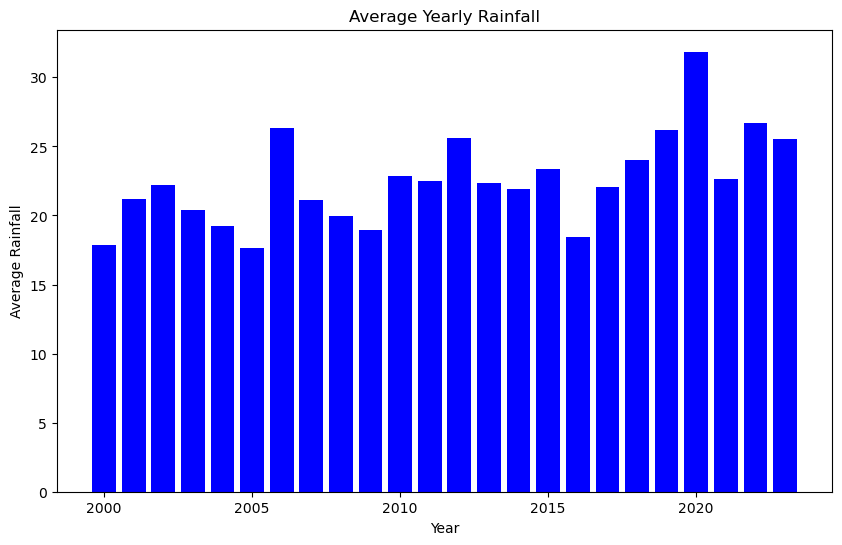

In [32]:
import matplotlib.pyplot as plt

# Convert the FeatureCollection to a Python list
yearly_avg_rainfall_list = yearly_avg_rainfall_fc.getInfo()['features']

# Extract the year and average precipitation properties
years = [feature['properties']['year'] for feature in yearly_avg_rainfall_list]
avg_precipitation = [feature['properties']['avg_precipitation'] for feature in yearly_avg_rainfall_list]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(years, avg_precipitation, color='blue')

plt.title('Average Yearly Rainfall')
plt.xlabel('Year')
plt.ylabel('Average Rainfall')

plt.show()



In [93]:
# Specify export parameters
export_params = {
    'collection': yearly_rainfall_fc,
    'folder': 'earthengine',  # Specify the folder in Google Drive
    'fileNamePrefix': 'rainfalltotalyears',  # Specify the file name prefix
    'fileFormat': 'CSV'  # Specify the file format
}

# Export the table to Google Drive
task = ee.batch.Export.table.toDrive(**export_params)
task.start()

In [74]:
# Specify export parameters
export_params = {
    'collection': rainfallYears,
    'folder': 'earthengine',  # Specify the folder in Google Drive
    'fileNamePrefix': 'rainfalltotalyear',  # Specify the file name prefix
    'fileFormat': 'CSV'  # Specify the file format
}

# Export the table to Google Drive
task = ee.batch.Export.table.toDrive(**export_params)
task.start()